In [231]:
pip install evidently
pip install lightgbm

In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from evidently import Report
from evidently.presets import DataDriftPreset
from evidently.presets import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from scipy.stats import chi2_contingency
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier



In [232]:
df=pd.read_csv(r"~/Downloads/Lead Scoring.csv")

In [233]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

In [24]:
print("First 5 rows of the dataset")
print(df.head())
print("Basic Information about all the columns")
print(df.info())
print("Basic statistical description about dataset")
print(df.describe())
print("Shape of dataset")
print(df.shape)

First 5 rows of the dataset
                            Prospect ID  Lead Number              Lead Origin  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737                      API   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728                      API   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727  Landing Page Submission   
3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719  Landing Page Submission   
4  3256f628-e534-4826-9d63-4a8b88782852       660681  Landing Page Submission   

      Lead Source Do Not Email Do Not Call  Converted  TotalVisits  \
0      Olark Chat           No          No          0          0.0   
1  Organic Search           No          No          0          5.0   
2  Direct Traffic           No          No          1          2.0   
3  Direct Traffic           No          No          0          1.0   
4          Google           No          No          1          2.0   

   Total Time Spent on Website  Page Views Per Visit  ...  \
0  

Initially we have 9240 rows and 37 columns.

In [101]:
# Splitting the features and target variables.

X=df.drop('Converted', axis=1)
Y=df['Converted']

In [102]:
y=pd.DataFrame(Y)
print("This is my target column")
print(y.head())

This is my target column
   Converted
0          0
1          0
2          1
3          0
4          1


# Target Column EDA

Class distribution:
 Converted
0    5679
1    3561
Name: count, dtype: int64
Class distribution (%):
 Converted
0    61.461039
1    38.538961
Name: proportion, dtype: float64
Visual representation


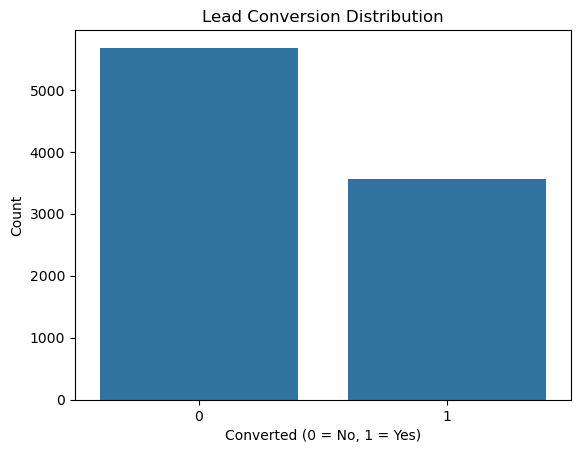

In [55]:
print("Class distribution:\n", y['Converted'].value_counts())
print("Class distribution (%):\n", y['Converted'].value_counts(normalize=True)*100)

print("Visual representation")
sns.countplot(x='Converted', data=df)
plt.title("Lead Conversion Distribution")
plt.xlabel("Converted (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

The data is moderately imbalanced, but not severely — ~38.5% of leads have converted.
This is good for training — we still need to monitor Recall, Precision, AUC, but aggressive resampling may not be necessary.
We will use class_weight='balanced' in models like LogisticRegression, RandomForest, XGBoost to handle the slight skew and avoid undersampling (we’ll lose data).

# Splitting catagorical and numerical features seperately because their EDA processes differ.

In [103]:
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['number']).columns.tolist()

print("Categorical Columns:\n", categorical_cols)
print("\nNumerical Columns:\n", numerical_cols)

Categorical Columns:
 ['Prospect ID', 'Lead Origin', 'Lead Source', 'Do Not Email', 'Do Not Call', 'Last Activity', 'Country', 'Specialization', 'How did you hear about X Education', 'What is your current occupation', 'What matters most to you in choosing a course', 'Search', 'Magazine', 'Newspaper Article', 'X Education Forums', 'Newspaper', 'Digital Advertisement', 'Through Recommendations', 'Receive More Updates About Our Courses', 'Tags', 'Lead Quality', 'Update me on Supply Chain Content', 'Get updates on DM Content', 'Lead Profile', 'City', 'Asymmetrique Activity Index', 'Asymmetrique Profile Index', 'I agree to pay the amount through cheque', 'A free copy of Mastering The Interview', 'Last Notable Activity']

Numerical Columns:
 ['Lead Number', 'TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit', 'Asymmetrique Activity Score', 'Asymmetrique Profile Score']


In [30]:
# Categorical: unique values + count
print("\n--- CATEGORICAL COLUMN ANALYSIS ---\n")
for col in categorical_cols:
    unique_vals = df[col].dropna().unique()
    print(f"{col}:")
    print(f"  Unique Count: {df[col].nunique(dropna=True)}")
    print(f"  Unique Values: {unique_vals[:10]}{' ...' if len(unique_vals) > 10 else ''}\n")


--- CATEGORICAL COLUMN ANALYSIS ---

Prospect ID:
  Unique Count: 9240
  Unique Values: ['7927b2df-8bba-4d29-b9a2-b6e0beafe620'
 '2a272436-5132-4136-86fa-dcc88c88f482'
 '8cc8c611-a219-4f35-ad23-fdfd2656bd8a'
 '0cc2df48-7cf4-4e39-9de9-19797f9b38cc'
 '3256f628-e534-4826-9d63-4a8b88782852'
 '2058ef08-2858-443e-a01f-a9237db2f5ce'
 '9fae7df4-169d-489b-afe4-0f3d752542ed'
 '20ef72a2-fb3b-45e0-924e-551c5fa59095'
 'cfa0128c-a0da-4656-9d47-0aa4e67bf690'
 'af465dfc-7204-4130-9e05-33231863c4b5'] ...

Lead Origin:
  Unique Count: 5
  Unique Values: ['API' 'Landing Page Submission' 'Lead Add Form' 'Lead Import'
 'Quick Add Form']

Lead Source:
  Unique Count: 21
  Unique Values: ['Olark Chat' 'Organic Search' 'Direct Traffic' 'Google' 'Referral Sites'
 'Welingak Website' 'Reference' 'google' 'Facebook' 'blog'] ...

Do Not Email:
  Unique Count: 2
  Unique Values: ['No' 'Yes']

Do Not Call:
  Unique Count: 2
  Unique Values: ['No' 'Yes']

Last Activity:
  Unique Count: 17
  Unique Values: ['Page Vis

From categorical features we will removeProspect ID as it is not actually a feature then we will remove (Magazine, Receive More Updates About Our Courses, Update me on Supply Chain Content, Get updates on DM Content, I agree to pay the amount through cheque) as they only have 1 value means they don't have any predictive power, then (Do Not Email, Do Not Call, Search, Newspaper Article, X Education Forums, Newspaper, Digital Advertisement, Through Recommendations, A free copy of Mastering The Interview) are binary columns so we don't have to encode them much, then we have (Lead Quality, Asymmetrique Activity Index, Asymmetrique Profile Index) as ordinal columns where we will use label encoder, then the rest of the columns haave more than 2 discret unique values and are nominal so we should idealy use one hot encoder but it will result in more tha 100 columns which is not ideal so we will first check which columns are actually revelant in prediction and then we will try to group them and then encode them using one-hot-encoder.

In [104]:
# Handling categorical columns

import pandas as pd

def clean_and_encode_nominal_heavy_grouping(df, nominal_cols, freq_threshold=0.3, max_categories=3):
    df = df.copy()
    encoded_df = pd.DataFrame(index=df.index)
    
    for col in nominal_cols:
        df[col] = df[col].replace('Select', pd.NA)
        df[col] = df[col].fillna('Unknown')

        value_counts = df[col].value_counts(normalize=True)
        frequent_cats = value_counts[value_counts >= freq_threshold].index.tolist()
        if len(frequent_cats) > max_categories:
            frequent_cats = value_counts.head(max_categories).index.tolist()

        df[col] = df[col].apply(lambda x: x if x in frequent_cats else 'Other')

        dummies = pd.get_dummies(df[col], prefix=col, drop_first=False)
        encoded_df = pd.concat([encoded_df, dummies], axis=1)
    
    return encoded_df

def preprocess_categorical_features(df):
    df = df.copy()

    # Step 1: Drop irrelevant/constant columns
    drop_cols = [
        'Prospect ID',
        'Magazine',
        'Receive More Updates About Our Courses',
        'Update me on Supply Chain Content',
        'Get updates on DM Content',
        'I agree to pay the amount through cheque'
    ]
    df.drop(columns=drop_cols, inplace=True, errors='ignore')

    # Step 2: Encode binary columns
    binary_cols = [
        'Do Not Email', 'Do Not Call', 'Search',
        'Newspaper Article', 'X Education Forums',
        'Newspaper', 'Digital Advertisement',
        'Through Recommendations', 'A free copy of Mastering The Interview'
    ]

    for col in binary_cols:
        if col in df.columns:
            df[col] = df[col].map({'Yes': 1, 'No': 0})

    # Step 3: Encode ordinal columns
    ordinal_mappings = {
        'Lead Quality': {
            'Worst': 0,
            'Low in Relevance': 1,
            'Not Sure': 2,
            'Might be': 3,
            'High in Relevance': 4
        },
        'Asymmetrique Activity Index': {
            '03.Low': 0,
            '02.Medium': 1,
            '01.High': 2
        },
        'Asymmetrique Profile Index': {
            '03.Low': 0,
            '02.Medium': 1,
            '01.High': 2
        }
    }

    for col, mapping in ordinal_mappings.items():
        if col in df.columns:
            df[col] = df[col].map(mapping)

    # Step 4: Identify nominal columns for encoding
    all_cat_cols = df.select_dtypes(include='object').columns.tolist()
    nominal_cols = [
        col for col in all_cat_cols
        if col not in ordinal_mappings and col not in drop_cols and col not in binary_cols
    ]

    # Step 5: Encode nominal columns with grouping
    encoded_nominal_df = clean_and_encode_nominal_heavy_grouping(df, nominal_cols, freq_threshold=0.3, max_categories=3)

    # Step 6: Drop original nominal columns and merge encoded columns
    df.drop(columns=nominal_cols, inplace=True)
    df = pd.concat([df, encoded_nominal_df], axis=1)

    return df


In [108]:
# Calling the function to handle categorical columns

df = preprocess_categorical_features(df)

We started by removing irrelevant categorical columns that had either only a single unique value or no predictive power, such as Prospect ID and certain constant columns. Next, we encoded binary categorical variables by mapping their Yes/No values to 1/0 for straightforward numerical processing. For ordinal categorical features like Lead Quality and Asymmetrique Activity/Profile Indexes, we applied custom label encoding to preserve their inherent order. The remaining nominal categorical columns, which had many unique categories, were first analyzed for predictive power and category frequency. We grouped less frequent categories into an "Other" class to reduce dimensionality and then applied one-hot encoding to the top categories. This approach balanced maintaining important information while avoiding an explosion in the number of features. Finally, we combined all processed categorical data into a single dataframe, resulting in a compact, machine-learning-ready dataset with 46 columns, including one-hot encoded boolean flags, ordinal labels, and binary variables.

In [109]:
# print("nominal columns: ")
print("This is my final df after handling calegorical columns")
print(df.info())

This is my final df after handling calegorical columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 46 columns):
 #   Column                                                                 Non-Null Count  Dtype  
---  ------                                                                 --------------  -----  
 0   Lead Number                                                            9240 non-null   int64  
 1   Do Not Email                                                           9240 non-null   int64  
 2   Do Not Call                                                            9240 non-null   int64  
 3   Converted                                                              9240 non-null   int64  
 4   TotalVisits                                                            9103 non-null   float64
 5   Total Time Spent on Website                                            9240 non-null   int64  
 6   Page Views Per Visit             

In [110]:
# Numerical: value ranges
print("\n--- NUMERICAL COLUMN ANALYSIS ---\n")
for col in numerical_cols:
    min_val = df[col].min()
    max_val = df[col].max()
    print(f"{col}:")
    print(f"  Range: {min_val} to {max_val}\n")


--- NUMERICAL COLUMN ANALYSIS ---

Lead Number:
  Range: 579533 to 660737

TotalVisits:
  Range: 0.0 to 251.0

Total Time Spent on Website:
  Range: 0 to 2272

Page Views Per Visit:
  Range: 0.0 to 55.0

Asymmetrique Activity Score:
  Range: 7.0 to 18.0

Asymmetrique Profile Score:
  Range: 11.0 to 20.0



In [117]:
# Removing the Lead Number and Converted columns as it is not a predictive feature

df=df.drop(['Lead Number', 'Converted'], axis=1)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 44 columns):
 #   Column                                                                 Non-Null Count  Dtype  
---  ------                                                                 --------------  -----  
 0   Do Not Email                                                           9240 non-null   int64  
 1   Do Not Call                                                            9240 non-null   int64  
 2   TotalVisits                                                            9103 non-null   float64
 3   Total Time Spent on Website                                            9240 non-null   int64  
 4   Page Views Per Visit                                                   9103 non-null   float64
 5   Search                                                                 9240 non-null   int64  
 6   Newspaper Article                                                      9240 non-null   i

# Optimize Data Types

In [125]:
def optimize_dtypes(df):
    df = df.copy()

    # Convert ordinal floats to category
    ordinal_cols = ['Lead Quality', 'Asymmetrique Activity Index', 'Asymmetrique Profile Index']
    for col in ordinal_cols:
        if col in df.columns:
            df[col] = df[col].astype('category')

    # Convert binary int64 columns (0/1) to bool
    binary_int_cols = [
        'Do Not Email', 'Do Not Call', 'Search',
        'Newspaper Article', 'X Education Forums',
        'Newspaper', 'Digital Advertisement',
        'Through Recommendations', 'A free copy of Mastering The Interview'
    ]
    for col in binary_int_cols:
        if col in df.columns:
            unique_vals = df[col].dropna().unique()
            if set(unique_vals).issubset({0,1}):
                df[col] = df[col].astype('bool')

    # Numerical columns (keep as is): TotalVisits, Total Time Spent on Website, Page Views Per Visit, Asymmetrique Activity Score, Asymmetrique Profile Score

    return df

# Usage
df = optimize_dtypes(df)
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 44 columns):
 #   Column                                                                 Non-Null Count  Dtype   
---  ------                                                                 --------------  -----   
 0   Do Not Email                                                           9240 non-null   bool    
 1   Do Not Call                                                            9240 non-null   bool    
 2   TotalVisits                                                            9103 non-null   float64 
 3   Total Time Spent on Website                                            9240 non-null   int64   
 4   Page Views Per Visit                                                   9103 non-null   float64 
 5   Search                                                                 9240 non-null   bool    
 6   Newspaper Article                                                      9240 non-

# Numerical Col's EDA

In [136]:
def numerical_eda(df, target):
    # Select numerical columns
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

    print("Summary statistics:")
    print(df[num_cols].describe())

    print("\nMissing values (%):")
    print(df[num_cols].isnull().mean() * 100)

    # Distribution plots
    for col in num_cols:
        plt.figure(figsize=(8, 4))
        sns.histplot(df[col].dropna(), kde=True)
        plt.title(f'Distribution of {col}')
        plt.show()

    # Boxplots for outlier detection
    for col in num_cols:
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot of {col}')
        plt.show()

Summary statistics:
       TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
count  9103.000000                  9240.000000           9103.000000   
mean      3.445238                   487.698268              2.362820   
std       4.854853                   548.021466              2.161418   
min       0.000000                     0.000000              0.000000   
25%       1.000000                    12.000000              1.000000   
50%       3.000000                   248.000000              2.000000   
75%       5.000000                   936.000000              3.000000   
max     251.000000                  2272.000000             55.000000   

       Asymmetrique Activity Score  Asymmetrique Profile Score  
count                  5022.000000                 5022.000000  
mean                     14.306252                   16.344883  
std                       1.386694                    1.811395  
min                       7.000000                   11.000000

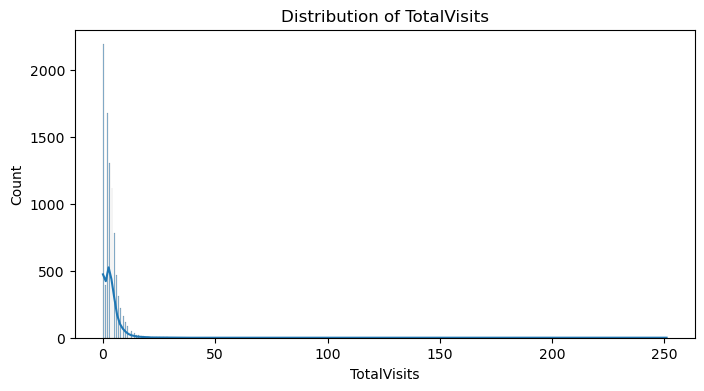

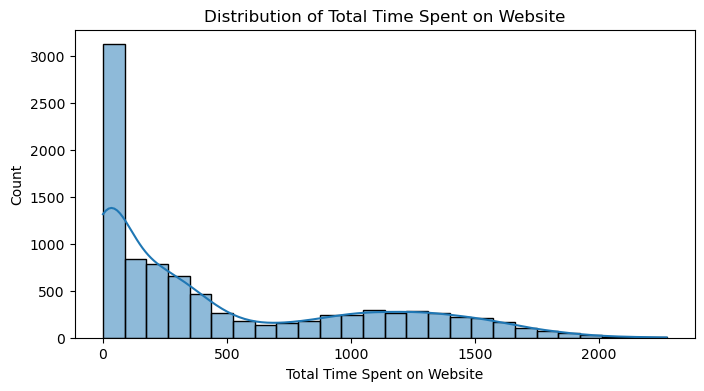

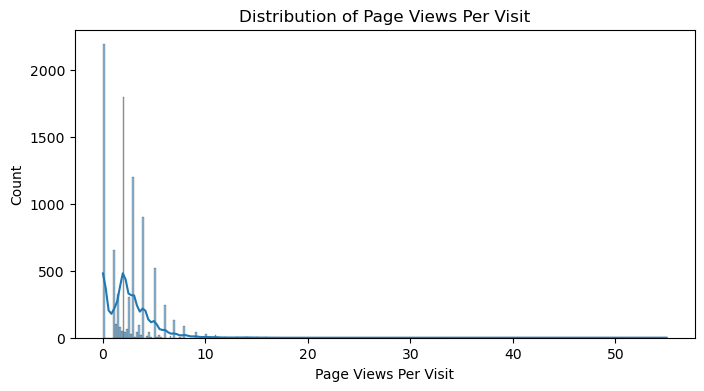

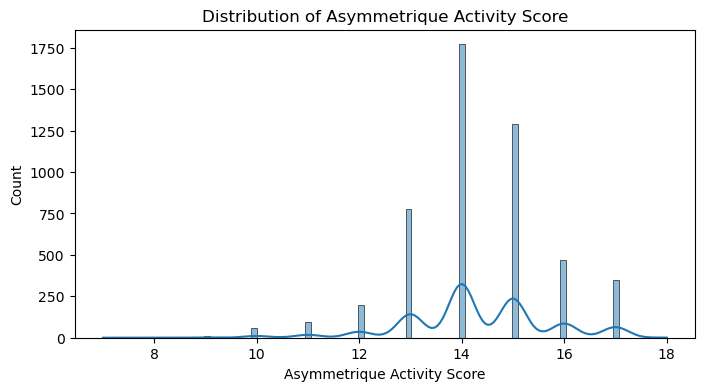

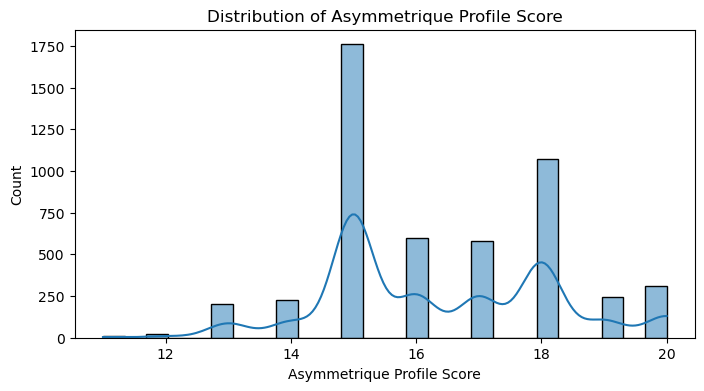

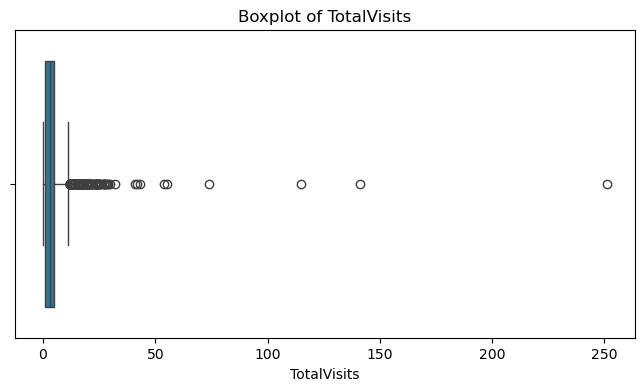

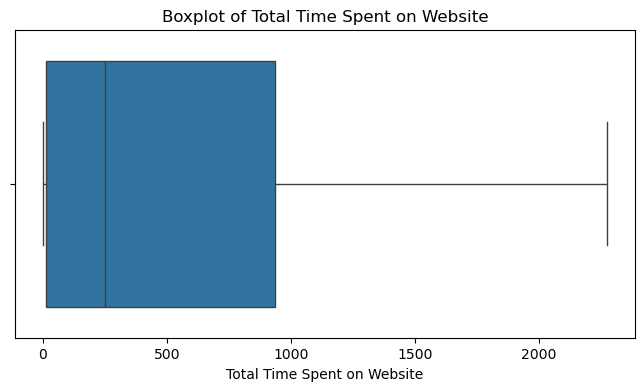

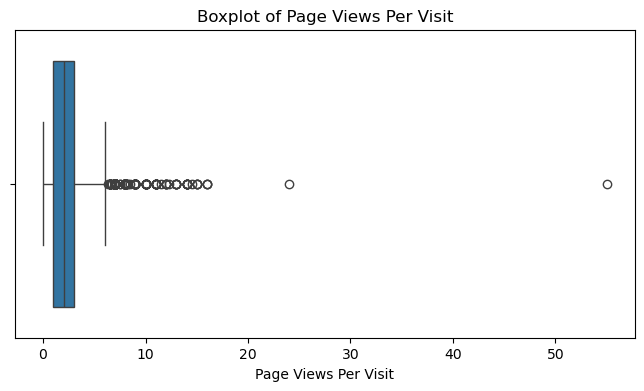

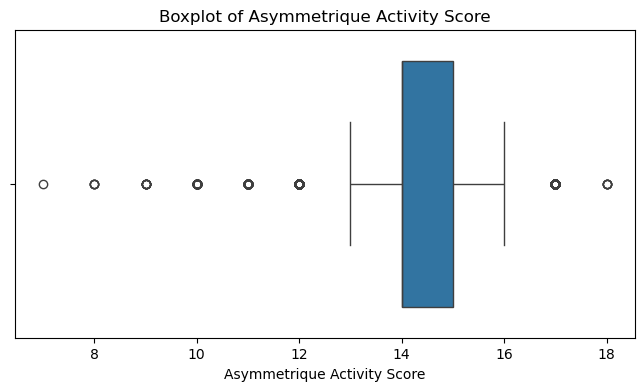

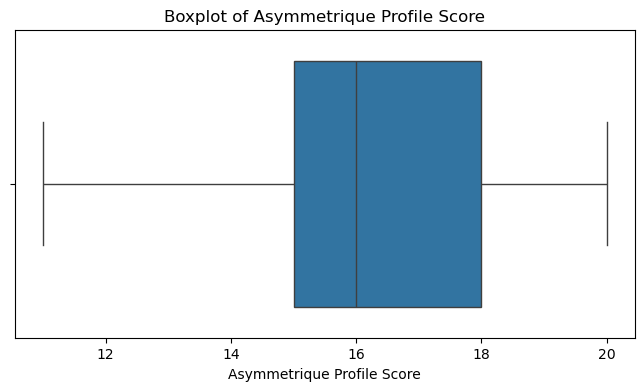


Correlation of numerical features with target:
Asymmetrique Activity Score   NaN
Asymmetrique Profile Score    NaN
Converted                     NaN
Page Views Per Visit          NaN
Total Time Spent on Website   NaN
TotalVisits                   NaN
dtype: float64


In [130]:
# Calling the function for numerical column's EDA
numerical_eda(df, y)

In [140]:
def quantify_skewness_outliers(df):
    results = []

    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

    for col in numerical_cols:
        series = df[col].dropna()
        skewness = series.skew()

        # IQR for outlier detection
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1

        # Define outlier bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Count outliers
        outliers = series[(series < lower_bound) | (series > upper_bound)]
        num_outliers = outliers.shape[0]

        results.append({
            'Feature': col,
            'Skewness': skewness,
            'Outliers Count': num_outliers,
            'Total Count': series.shape[0],
            'Outlier Percentage': (num_outliers / series.shape[0]) * 100
        })

    return pd.DataFrame(results)

In [142]:
# We used IQR for outlier detection because it’s a simple, robust method that doesn’t assume any data distribution.
# IQR focuses on the middle 50% of the data and flags points outside 1.5 times the IQR as outliers, 
# effectively capturing extreme values without being influenced by skewed data or mean shifts.

skew_outliers_df = quantify_skewness_outliers(df)
skew_outliers_df

,Feature,Skewness,Outliers Count,Total Count,Outlier Percentage
0,TotalVisits,19.911657,267,9103,2.933099
1,Total Time Spent on Website,0.956450,0,9240,0.000000
2,Page Views Per Visit,2.871793,360,9103,3.954740
3,Asymmetrique Activity Score,-0.383380,716,5022,14.257268
4,Asymmetrique Profile Score,0.221739,0,5022,0.000000


In [148]:
def handle_skew_and_outliers(df):
    df = df.copy()
    
    # Handle skewness with log transformation for heavily skewed features
    skewed_cols = ['TotalVisits', 'Page Views Per Visit']
    for col in skewed_cols:
        # Add 1 to avoid log(0)
        df[col] = np.log1p(df[col])
    
    # Handle outliers using IQR capping (winsorization)
    numeric_cols = ['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit',
                    'Asymmetrique Activity Score', 'Asymmetrique Profile Score']
    
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Cap values outside bounds to the bounds
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    
    return df

In [149]:
df=handle_skew_and_outliers(df)

In [150]:
# Checking skewness and outliers after transformations

skew_outliers_df = quantify_skewness_outliers(df)
skew_outliers_df

,Feature,Skewness,Outliers Count,Total Count,Outlier Percentage
0,TotalVisits,-0.192537,0,9103,0.0
1,Total Time Spent on Website,0.956450,0,9240,0.0
2,Page Views Per Visit,-0.326863,0,9103,0.0
3,Asymmetrique Activity Score,0.219879,0,5022,0.0
4,Asymmetrique Profile Score,0.221739,0,5022,0.0


In [160]:
# Separate features and target
X_num = df[['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit', 
                  'Asymmetrique Activity Score', 'Asymmetrique Profile Score']]
# y = df_final['Converted']

# 1. Calculate Pearson correlation with target (for numerical vars)
correlations = X_num.apply(lambda x: x.corr(Y))
print("Correlation with target:")
print(correlations)

# 2. Use RandomForest for feature importance (non-linear relation)
X_train, X_test, y_train, y_test = train_test_split(X_num, Y, test_size=0.2, random_state=42)
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

importances = pd.Series(rf.feature_importances_, index=X_num.columns).sort_values(ascending=False)
print("\nFeature Importances from RandomForest:")
print(importances)

Correlation with target:
TotalVisits                    0.018996
Total Time Spent on Website    0.362483
Page Views Per Visit          -0.015396
Asymmetrique Activity Score    0.179680
Asymmetrique Profile Score     0.218571
dtype: float64

Feature Importances from RandomForest:
Total Time Spent on Website    0.619948
Asymmetrique Activity Score    0.110976
Asymmetrique Profile Score     0.092076
TotalVisits                    0.089753
Page Views Per Visit           0.087247
dtype: float64


Total Time Spent on Website has the strongest linear correlation (0.36) with the target and also dominates feature importance (62%) in the Random Forest, making it the most predictive numerical feature.

Asymmetrique Profile Score and Asymmetrique Activity Score have moderate correlations (~0.18-0.22) and moderate importance (~9-11%), indicating they provide useful but less strong signals.

TotalVisits and Page Views Per Visit show very weak correlations (<0.02) and low importance (~8-9%), meaning their predictive power is limited, but they still contribute slightly.

Missing value percentages per column:
 Do Not Email                                                              0.000000
Do Not Call                                                               0.000000
TotalVisits                                                               1.482684
Total Time Spent on Website                                               0.000000
Page Views Per Visit                                                      1.482684
Search                                                                    0.000000
Newspaper Article                                                         0.000000
X Education Forums                                                        0.000000
Newspaper                                                                 0.000000
Digital Advertisement                                                     0.000000
Through Recommendations                                                   0.000000
Lead Quality                                    

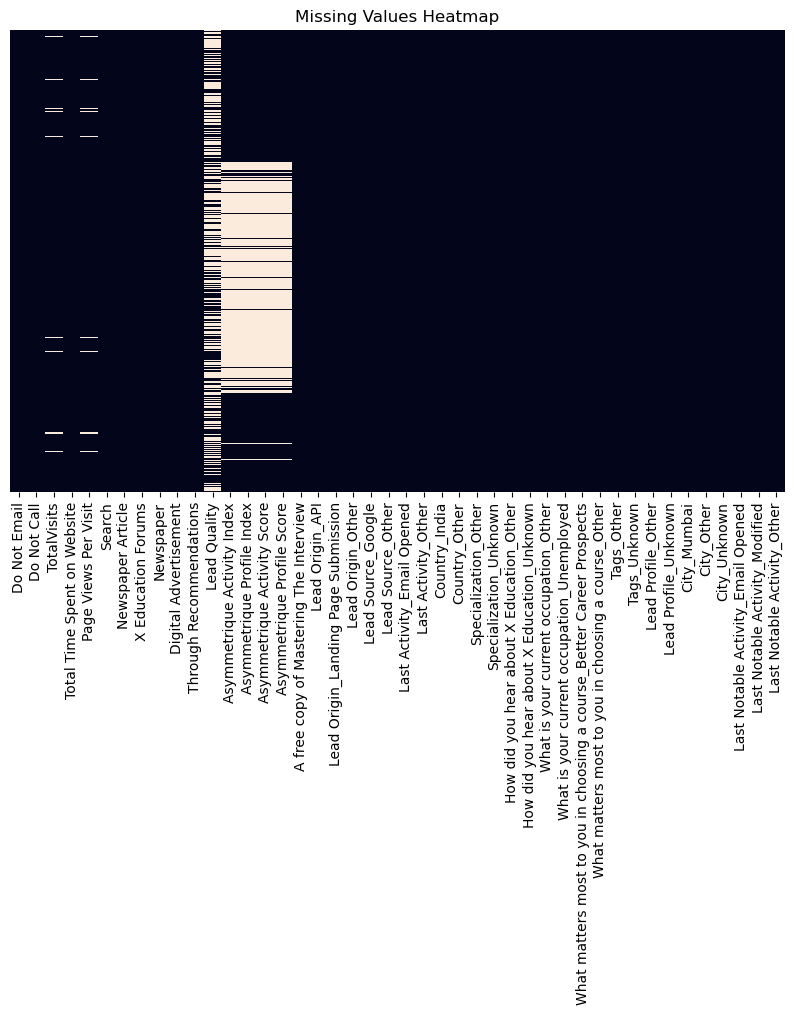

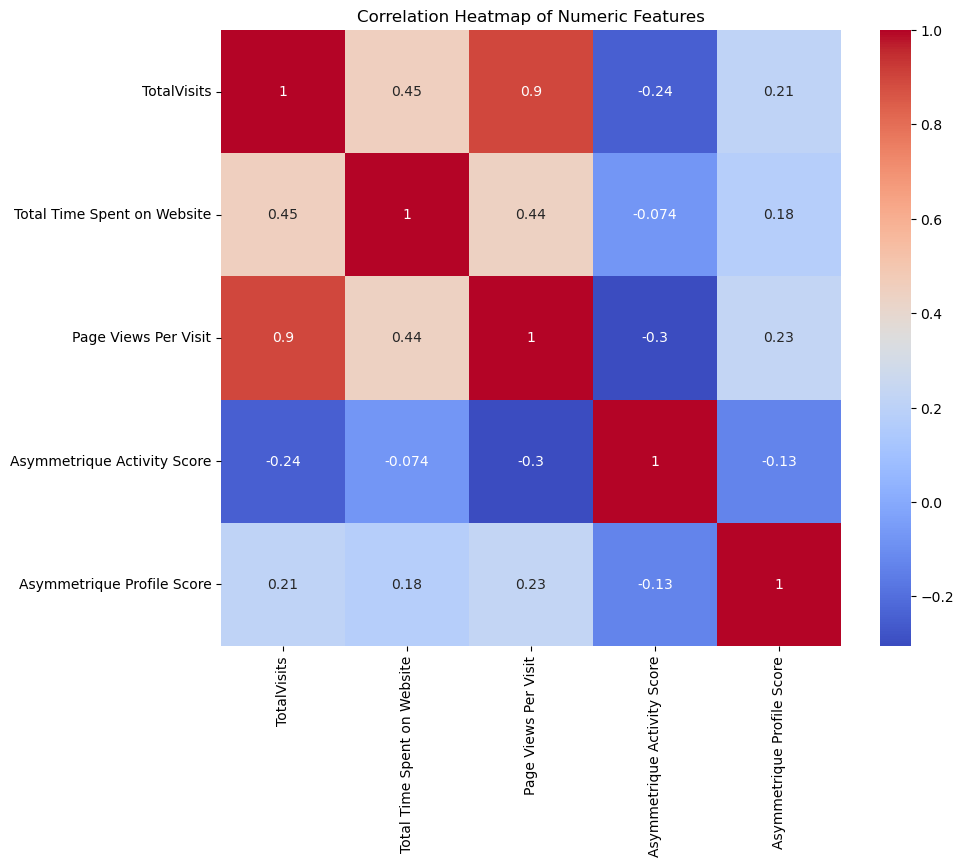

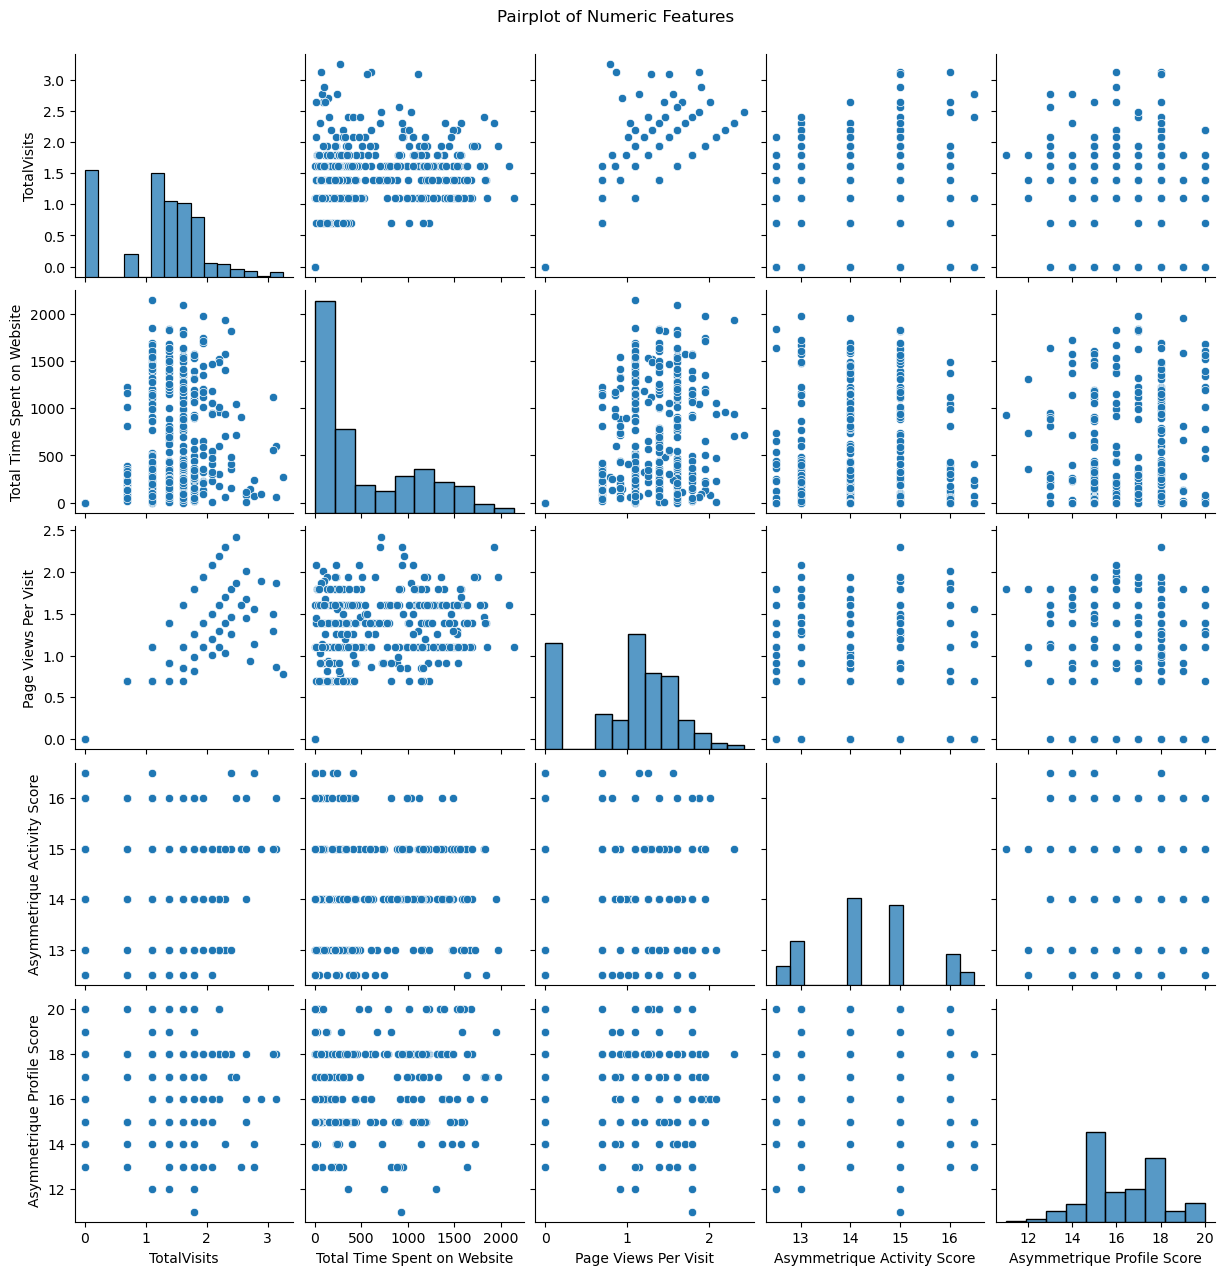

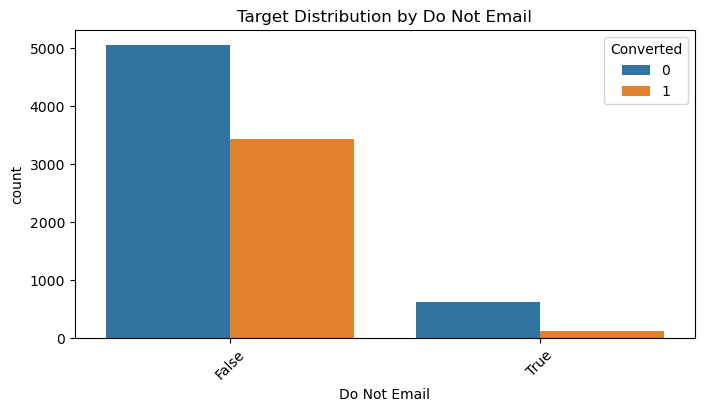

Chi-square test for Do Not Email - p-value: 0.0000


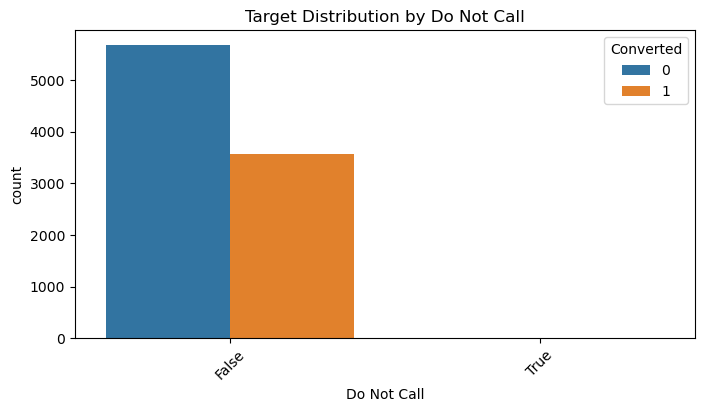

Chi-square test for Do Not Call - p-value: 0.2893


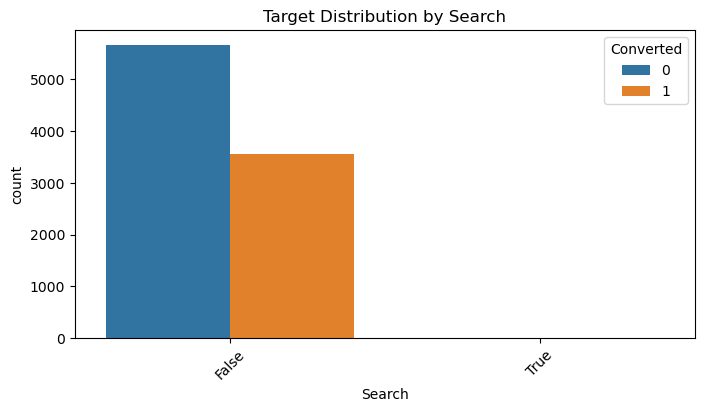

Chi-square test for Search - p-value: 1.0000


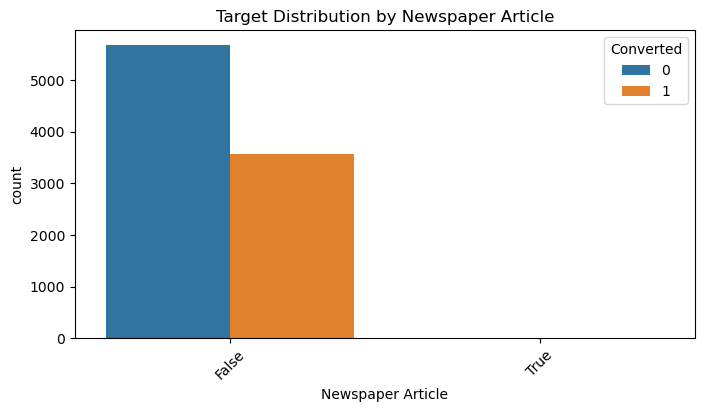

Chi-square test for Newspaper Article - p-value: 1.0000


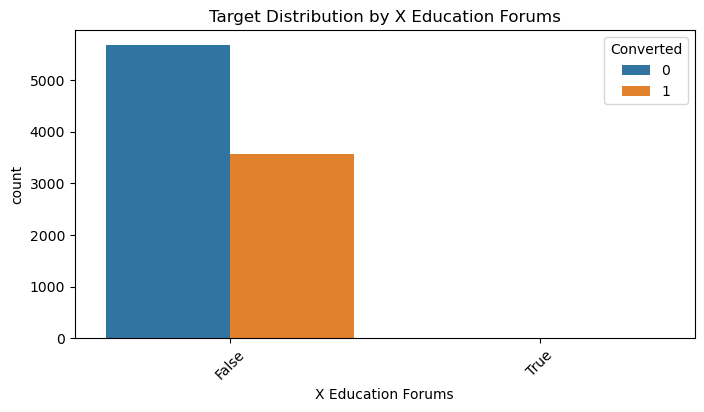

Chi-square test for X Education Forums - p-value: 1.0000


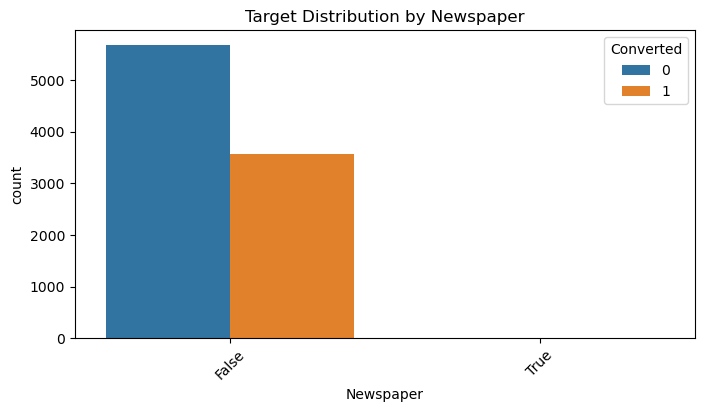

Chi-square test for Newspaper - p-value: 1.0000


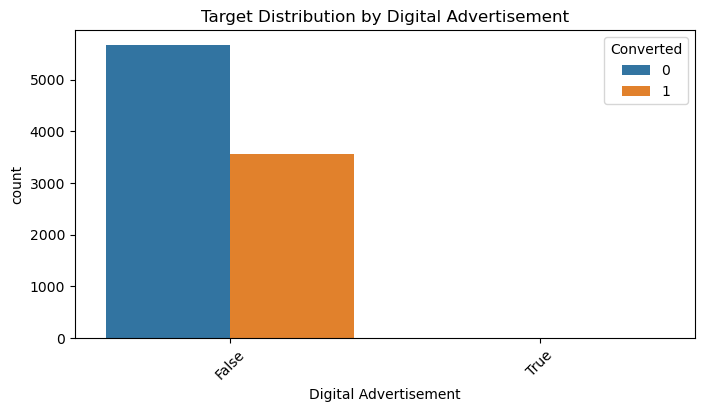

Chi-square test for Digital Advertisement - p-value: 0.9659


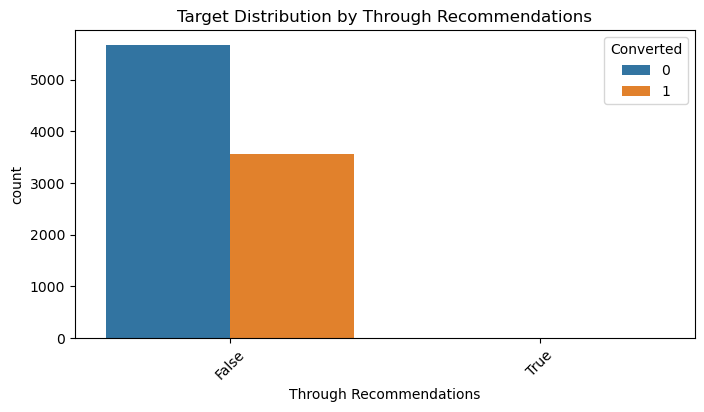

Chi-square test for Through Recommendations - p-value: 0.1615


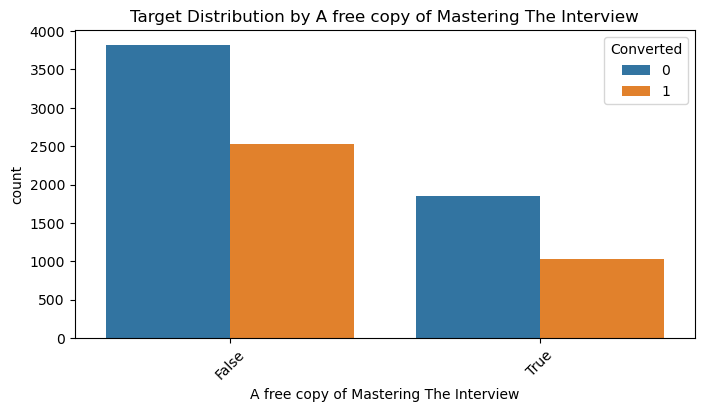

Chi-square test for A free copy of Mastering The Interview - p-value: 0.0001


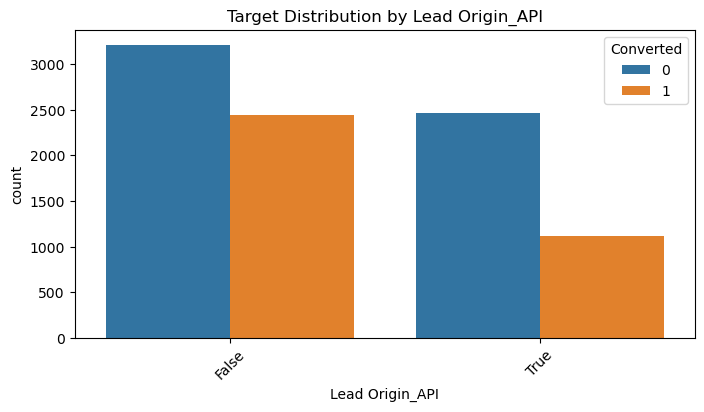

Chi-square test for Lead Origin_API - p-value: 0.0000


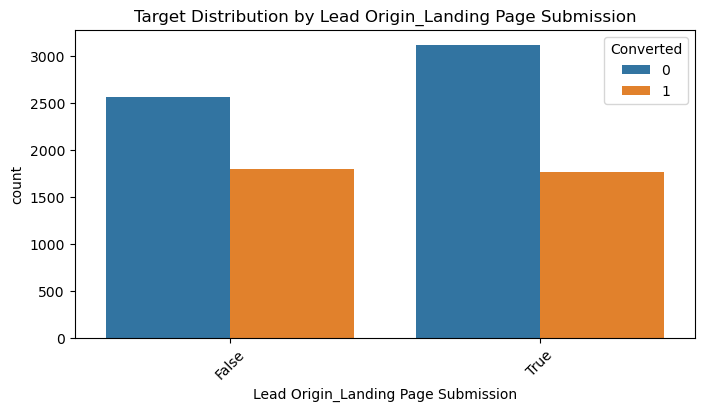

Chi-square test for Lead Origin_Landing Page Submission - p-value: 0.0000


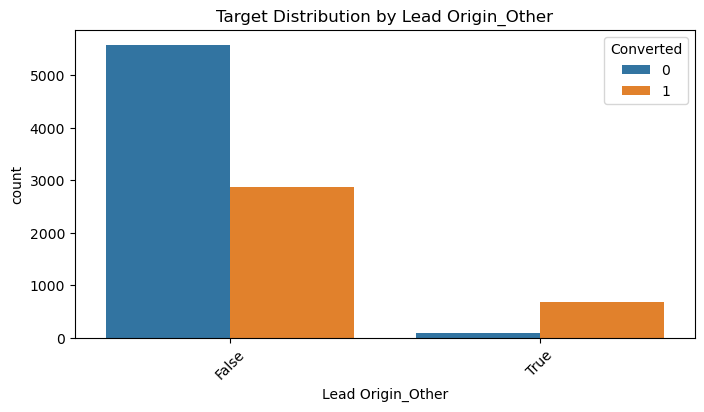

Chi-square test for Lead Origin_Other - p-value: 0.0000


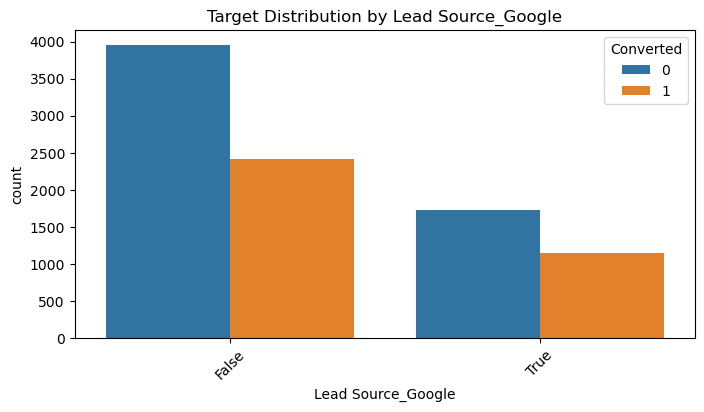

Chi-square test for Lead Source_Google - p-value: 0.0570


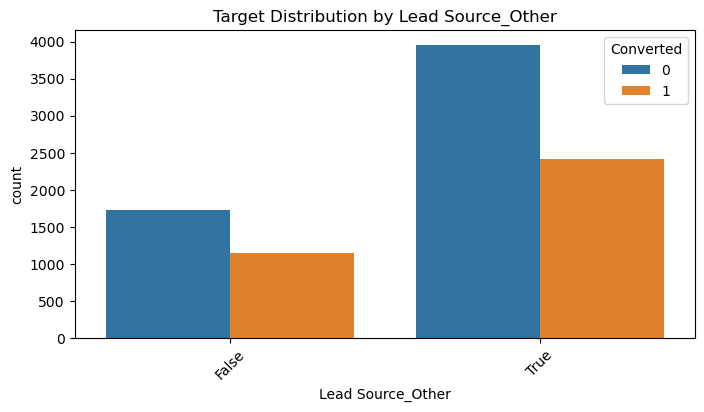

Chi-square test for Lead Source_Other - p-value: 0.0570


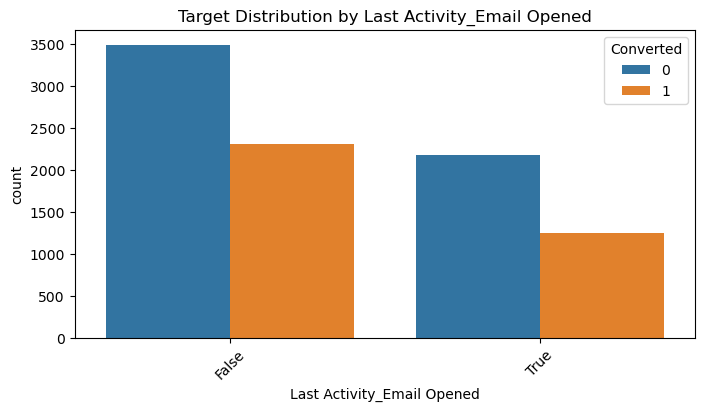

Chi-square test for Last Activity_Email Opened - p-value: 0.0017


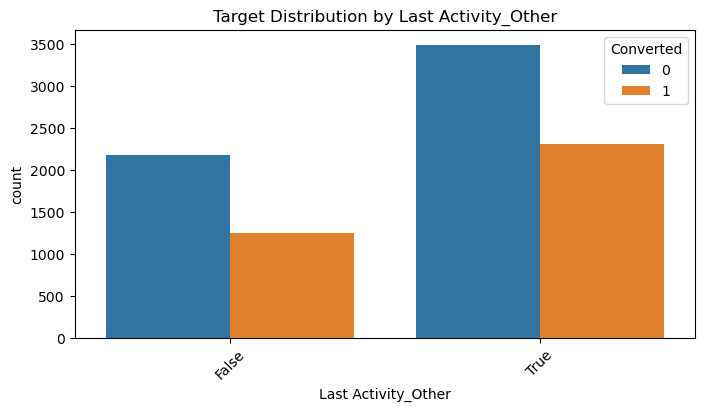

Chi-square test for Last Activity_Other - p-value: 0.0017


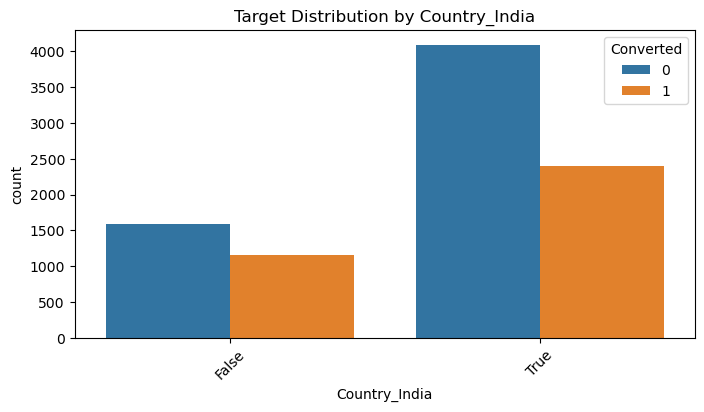

Chi-square test for Country_India - p-value: 0.0000


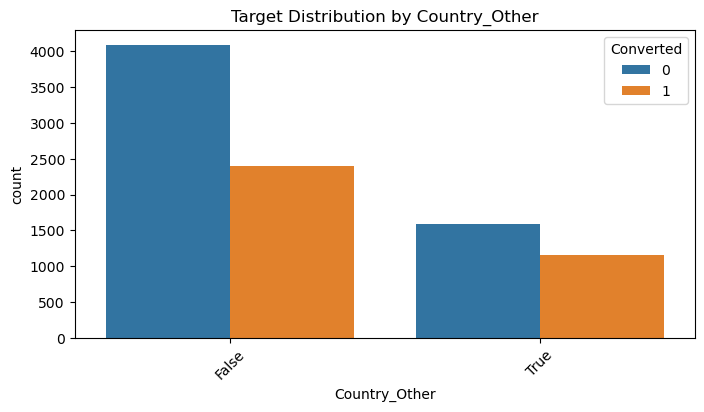

Chi-square test for Country_Other - p-value: 0.0000


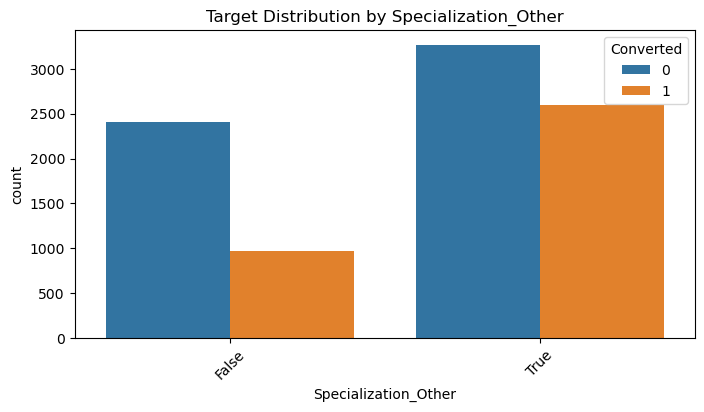

Chi-square test for Specialization_Other - p-value: 0.0000


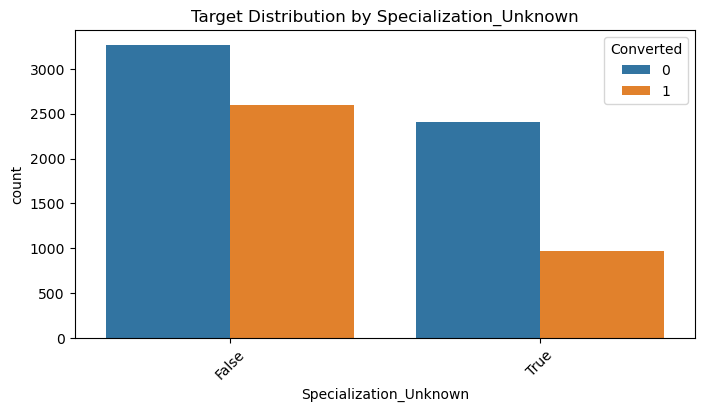

Chi-square test for Specialization_Unknown - p-value: 0.0000


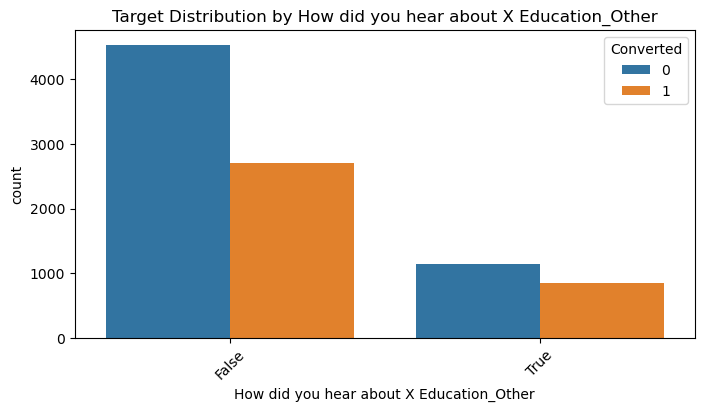

Chi-square test for How did you hear about X Education_Other - p-value: 0.0000


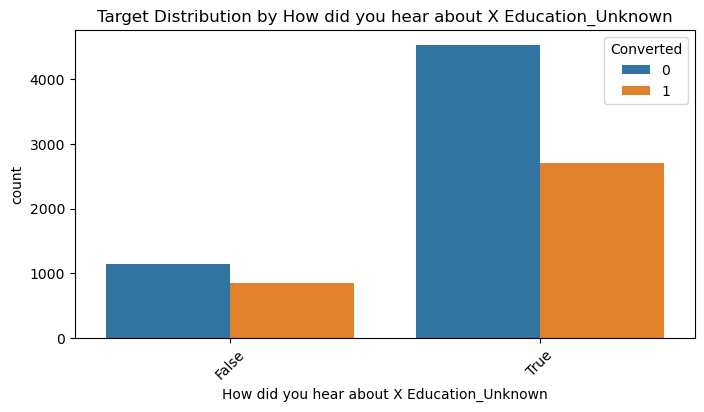

Chi-square test for How did you hear about X Education_Unknown - p-value: 0.0000


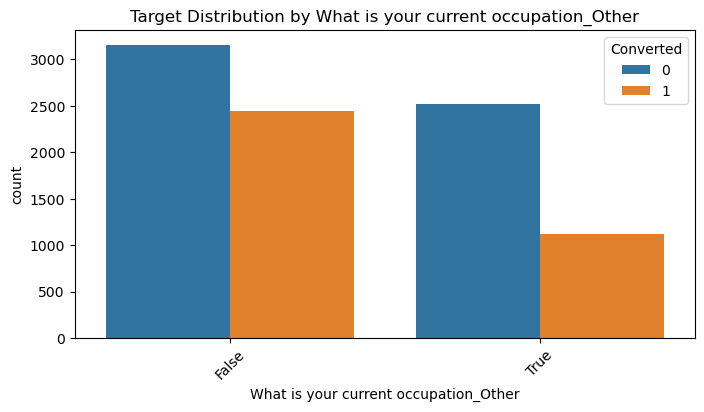

Chi-square test for What is your current occupation_Other - p-value: 0.0000


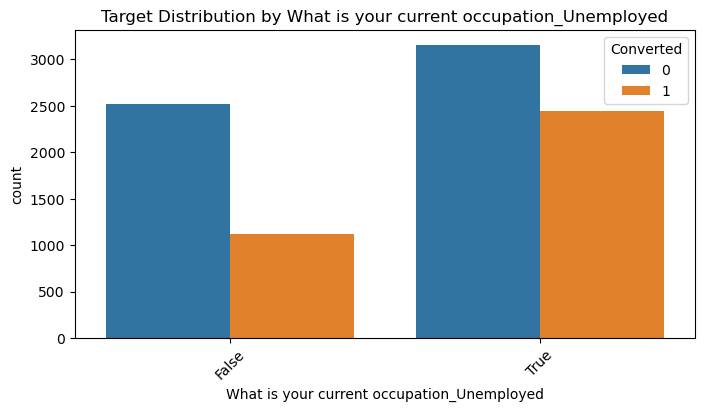

Chi-square test for What is your current occupation_Unemployed - p-value: 0.0000


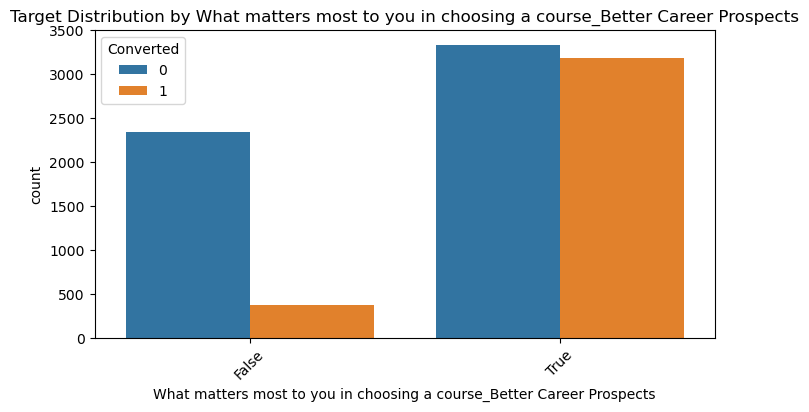

Chi-square test for What matters most to you in choosing a course_Better Career Prospects - p-value: 0.0000


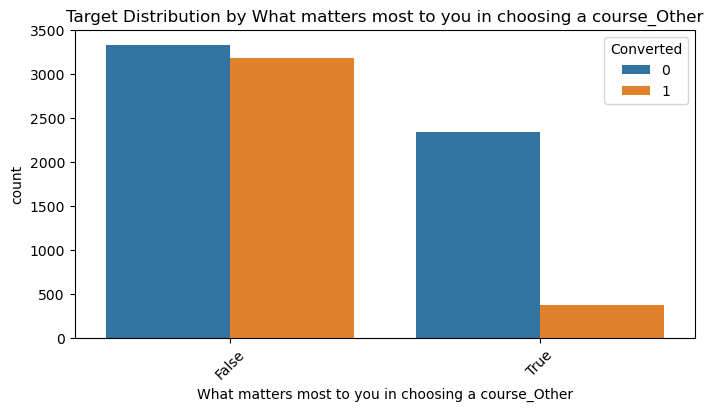

Chi-square test for What matters most to you in choosing a course_Other - p-value: 0.0000


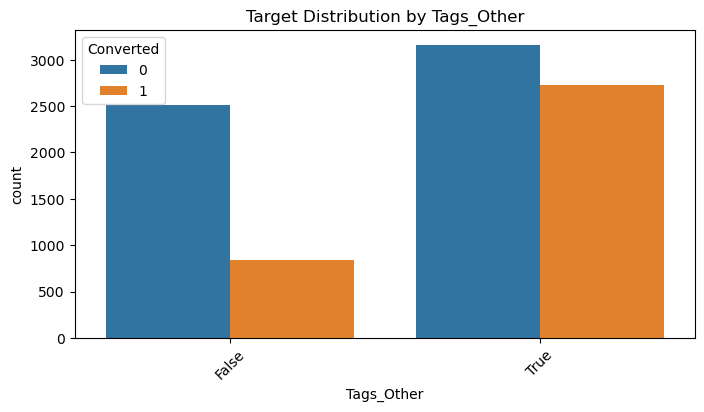

Chi-square test for Tags_Other - p-value: 0.0000


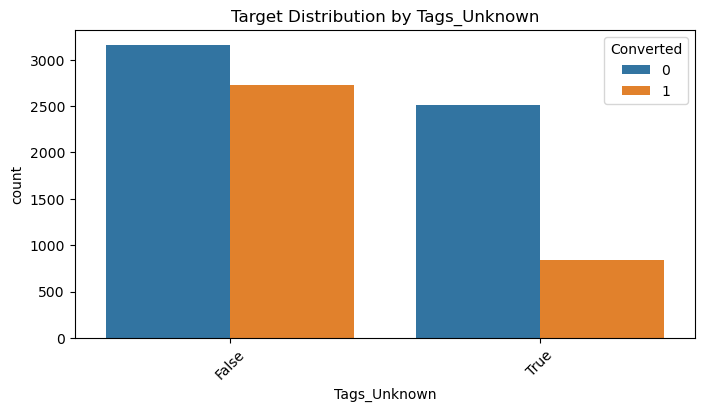

Chi-square test for Tags_Unknown - p-value: 0.0000


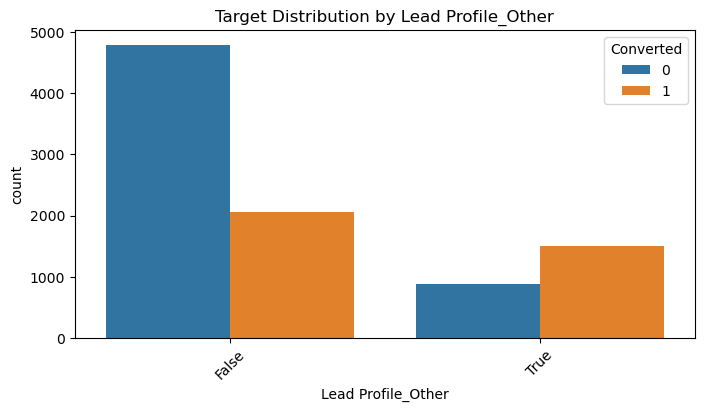

Chi-square test for Lead Profile_Other - p-value: 0.0000


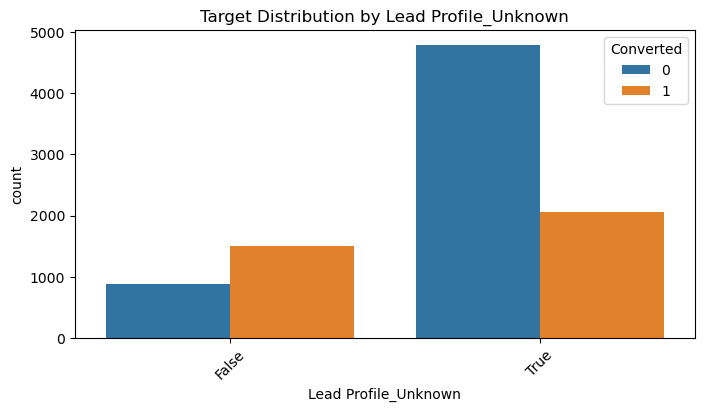

Chi-square test for Lead Profile_Unknown - p-value: 0.0000


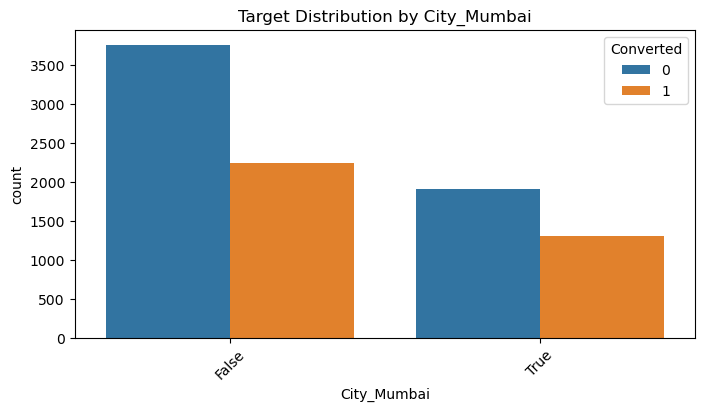

Chi-square test for City_Mumbai - p-value: 0.0027


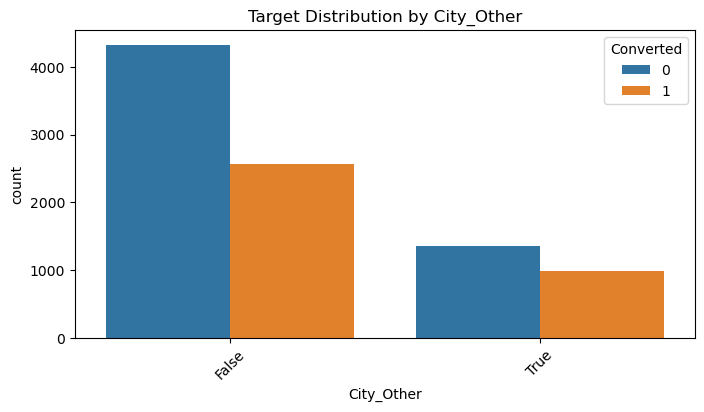

Chi-square test for City_Other - p-value: 0.0000


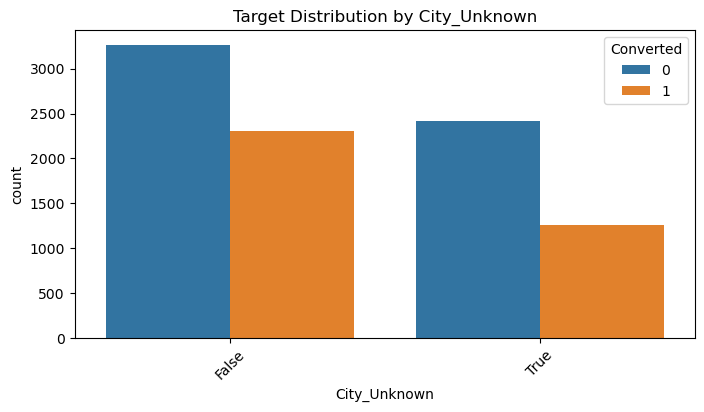

Chi-square test for City_Unknown - p-value: 0.0000


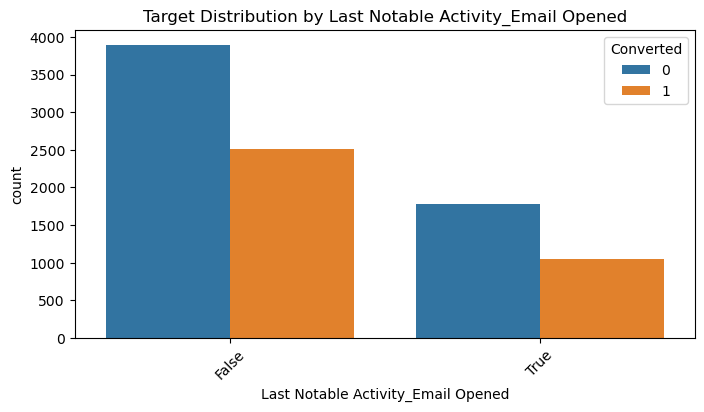

Chi-square test for Last Notable Activity_Email Opened - p-value: 0.0369


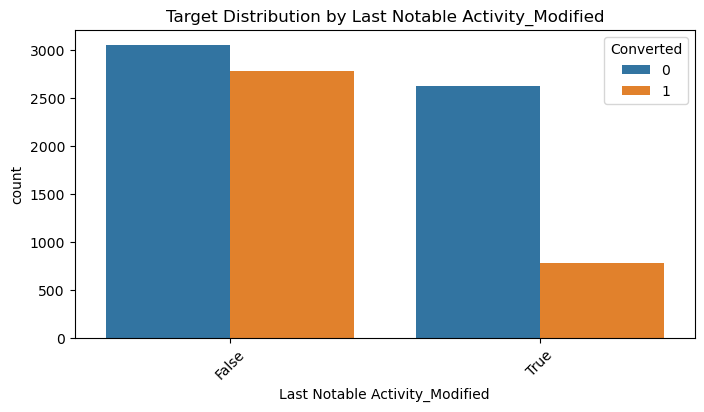

Chi-square test for Last Notable Activity_Modified - p-value: 0.0000


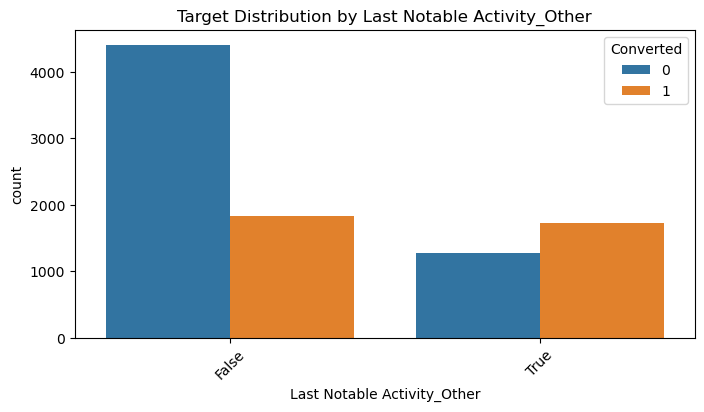

Chi-square test for Last Notable Activity_Other - p-value: 0.0000


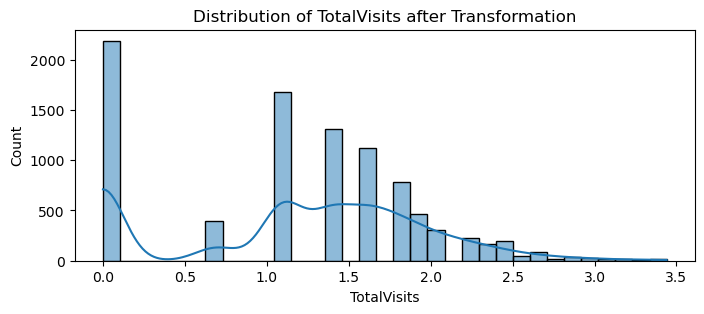

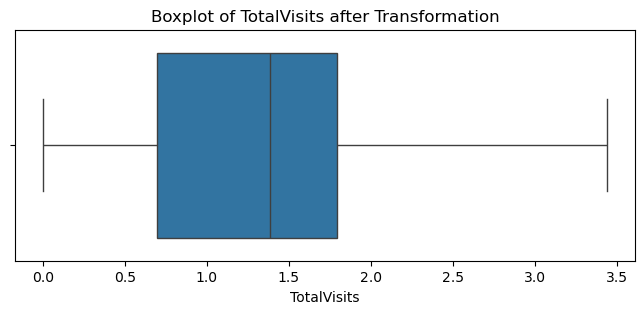

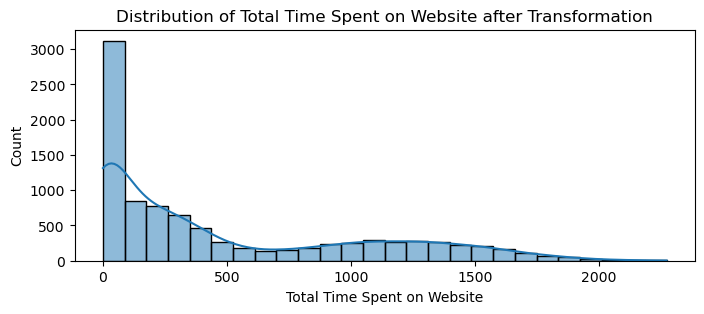

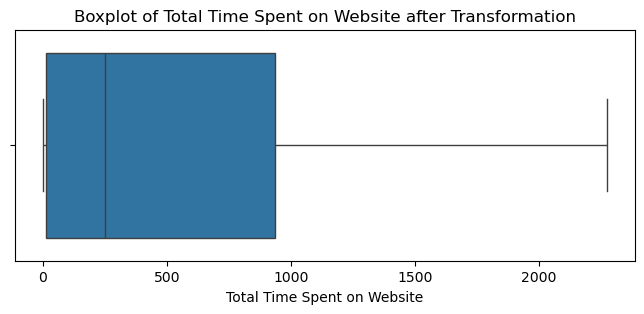

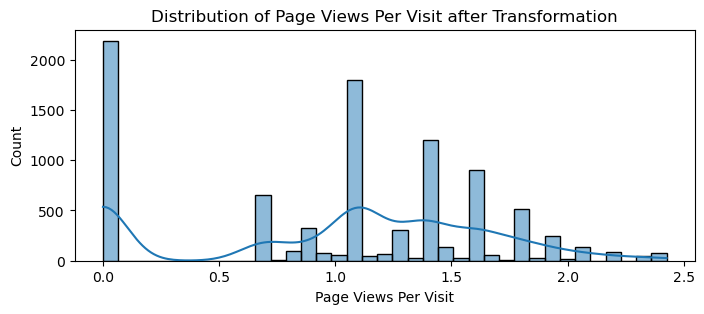

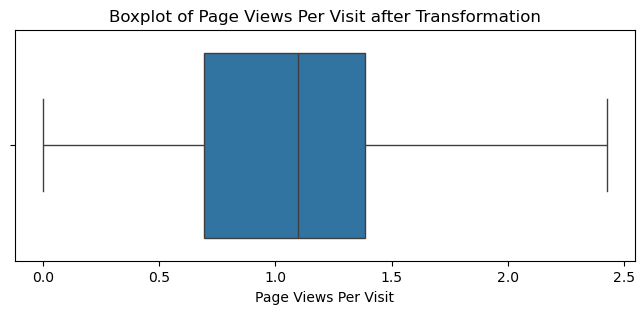

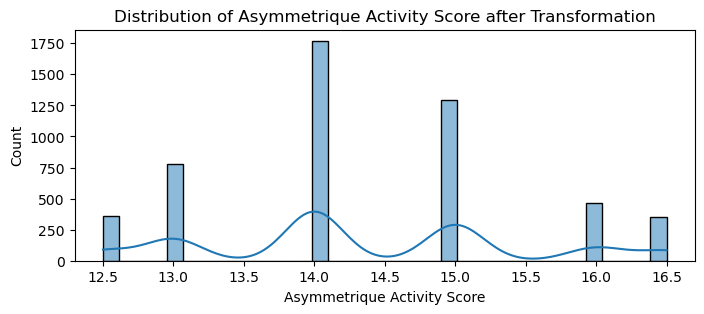

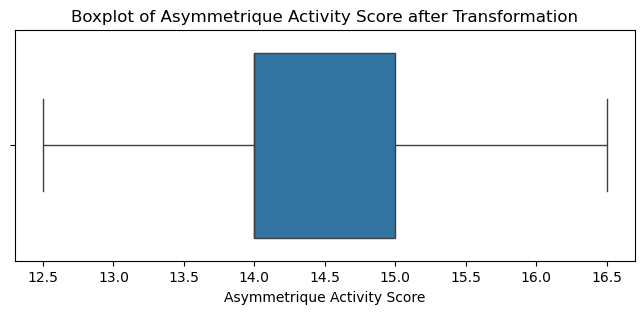

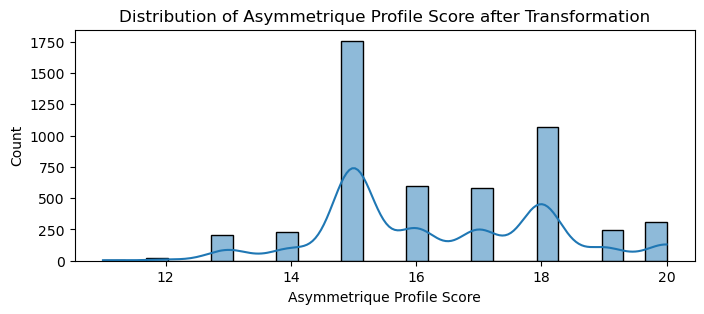

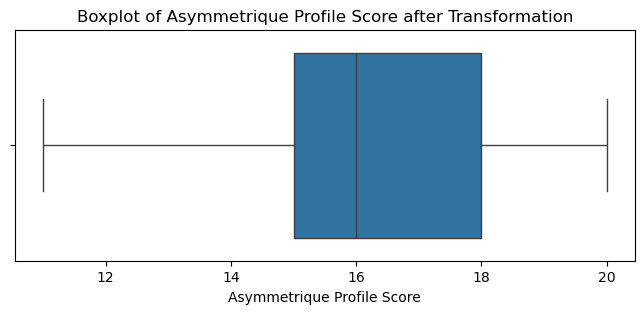

In [167]:
# 1. Analyze Missing Values
missing_percent = df.isnull().mean() * 100
print("Missing value percentages per column:\n", missing_percent)

# Visualize missingness
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()

# 2. Analyze Relationships Between Numeric Features
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

# Pairplot (sampling if dataset is large)
sns.pairplot(df[numeric_cols].sample(500))
plt.suptitle("Pairplot of Numeric Features", y=1.02)
plt.show()

# 3. Explore Categorical Features in Relation to Target
cat_cols = df.select_dtypes(include=['bool', 'object']).columns.tolist()
target_col = 'Converted'  # replace if different

for col in cat_cols:
    if df[col].nunique() < 10:  # limit to manageable unique values
        plt.figure(figsize=(8, 4))
        sns.countplot(x=col, hue=Y, data=df)
        plt.title(f"Target Distribution by {col}")
        plt.xticks(rotation=45)
        plt.show()

        # Chi-square test of independence
        contingency_table = pd.crosstab(df[col], Y)
        chi2, p, _, _ = chi2_contingency(contingency_table)
        print(f"Chi-square test for {col} - p-value: {p:.4f}")

# 4. Confirm Distributions and Outliers Post-Transformation
for col in numeric_cols:
    plt.figure(figsize=(8, 3))
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f"Distribution of {col} after Transformation")
    plt.show()
    
    plt.figure(figsize=(8, 3))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col} after Transformation")
    plt.show()

# 6. Finalize Feature Engineering Ideas
# Check interactions or create new features as per domain knowledge

# 7. Prepare Data Pipeline Outline (Example code snippet for imputation and scaling)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # median imputation for numeric
    ('scaler', StandardScaler())                     # scale numeric features
])

# Fit-transform example (replace df_num with actual numeric data)
# df_num_processed = numeric_pipeline.fit_transform(df[numeric_cols])



Missing Values:

Critical numeric columns like TotalVisits and Page Views Per Visit have very low missingness (~1.5%), manageable with imputation.

The Asymmetrique columns and Lead Quality have high missing rates (~45-51%), so consider if these should be imputed carefully, engineered separately, or dropped based on modeling impact.

Correlation Insights:

Strong positive correlation between TotalVisits and Page Views Per Visit (0.90) confirms frequent visitors tend to explore more pages.

Moderate positive correlations involving Time Spent suggest higher engagement is consistent across these metrics.

Negative correlations with Asymmetrique Activity Score indicate it measures different user behavior, likely more goal-directed or task-specific than general browsing.

Weak correlations elsewhere imply some features capture unique information.

Chi-Square Test Results on Categorical Features:

Do Not Email, etc is significantly associated with conversion (p < 0.001), so it's a useful predictor.

Do Not Call, Search, and Newspaper Article, etc show no significant association, suggesting limited predictive power.

# Data Cleaning

In this approach, we compared two different strategies for handling missing values to understand their impact on data consistency and potential drift. The first strategy (Approach A) was a simple imputation where all missing values across columns were filled with zero, which is straightforward but might oversimplify or distort the data, especially for ordinal or continuous features. The second strategy (Approach B) used a more thoughtful imputation: ordinal columns were filled with their mode to preserve categorical order and meaning, while numerical columns were filled with their median to reduce the effect of outliers. This setup helps maintain the underlying data distribution and relationships more accurately.

In [176]:
# from evidently.report import Report
# from evidently.metric_preset import DataDriftPreset
from IPython.display import IFrame
# import pandas as pd

# Copy original DataFrame
df_base = df.copy()

# Identify columns with missing values
missing_cols = df_base.columns[df_base.isnull().any()]
num_cols = df_base.select_dtypes(include=['float64', 'int64']).columns
ord_cols = ['Lead Quality', 'Asymmetrique Activity Index', 'Asymmetrique Profile Index']

# Split numerical columns into ordinal and true numerical
ord_cols_in_df = [col for col in ord_cols if col in df_base.columns]
num_cols_clean = [col for col in num_cols if col in missing_cols and col not in ord_cols_in_df]

# --- Approach A: Simple Imputation (fill all with 0) ---
df_simple = df_base.copy()
df_simple[missing_cols] = df_simple[missing_cols].fillna(0)

# --- Approach B: Smarter Imputation ---
df_advanced = df_base.copy()

# Impute ordinal columns with mode
for col in ord_cols_in_df:
    df_advanced[col] = df_advanced[col].fillna(df_advanced[col].mode()[0])

# Impute numerical columns with median
for col in num_cols_clean:
    df_advanced[col] = df_advanced[col].fillna(df_advanced[col].median())

# --- Generate Data Drift Report ---
report = Report(metrics=[DataDriftPreset()])
rep=report.run(reference_data=df_simple, current_data=df_advanced)

# Save report
rep.save_html("data_drift_report_lead_conversion.html")

# Display inline (if using Jupyter)
IFrame(src="data_drift_report_lead_conversion.html", width=1000, height=600)


The generated data drift report compared these two datasets to detect if the imputation methods caused significant distributional shifts. The report identified drift in several important columns, highlighting that filling missing values with zero versus using mode/median imputation can lead to noticeable differences in feature distributions. This insight guides us to prefer more nuanced imputation methods (like in Approach B) to maintain data integrity and model performance, especially when missingness is substantial and potentially informative.

We handled missing values dynamically based on their percentage and data type to preserve data quality and meaningful patterns. For numerical columns with low missingness (<5%), we used median imputation for robustness against outliers. Moderate missingness (5%-50%) was addressed with KNN imputation, leveraging similarities in other features for more accurate filling. High missingness (>50%) prompted creating missingness indicator flags and filling with zero to retain missingness information without introducing bias.

For boolean columns, missing values were filled with False, assuming absence means a negative condition. In categorical columns, missing values with less than 50% missing were filled with the mode, preserving dominant categories, while those with higher missingness were filled with a new 'Unknown' category to avoid forcing incorrect imputations and to allow models to learn from missingness itself. This approach balances data integrity, business context, and model readiness effectively.

In [204]:
import pandas as pd
from sklearn.impute import KNNImputer

def handle_missing_values_v2(df, num_thresh_low=0.05, num_thresh_high=0.5, cat_thresh_high=0.5):
    df = df.copy()
    missing_report = df.isnull().mean()

    # Numeric columns
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    # Boolean columns
    bool_cols = df.select_dtypes(include=['bool', 'boolean']).columns.tolist()
    # Categorical columns (object + category)
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

    # Handle numeric columns
    for col in num_cols:
        missing_ratio = missing_report[col]
        if missing_ratio == 0:
            continue
        if missing_ratio < num_thresh_low:
            median_val = df[col].median()
            df[col].fillna(median_val, inplace=True)
        elif missing_ratio < num_thresh_high:
            # Will be handled by KNN later in bulk
            continue
        else:
            df[f'{col}_missing_flag'] = df[col].isnull().astype(int)
            df[col].fillna(0, inplace=True)

    # KNN imputation for numeric columns with moderate missingness
    knn_cols = [col for col in num_cols if num_thresh_low <= missing_report[col] < num_thresh_high]
    if knn_cols:
        knn_imputer = KNNImputer(n_neighbors=3)
        df[knn_cols] = knn_imputer.fit_transform(df[knn_cols])

    # Handle boolean columns
    for col in bool_cols:
        missing_ratio = missing_report[col]
        if missing_ratio == 0:
            continue
        df[col].fillna(False, inplace=True)  # Fill missing bools with False

    # Handle categorical columns
    for col in cat_cols:
        missing_ratio = missing_report[col]
        if missing_ratio == 0:
            continue

        if missing_ratio < cat_thresh_high:
            # Fill missing with mode (most frequent)
            mode_val = df[col].mode(dropna=True)[0] if not df[col].mode(dropna=True).empty else 'Unknown'
            if pd.api.types.is_categorical_dtype(df[col]):
                if mode_val not in df[col].cat.categories:
                    df[col] = df[col].cat.add_categories(mode_val)
            df[col].fillna(mode_val, inplace=True)
        else:
            # For very high missing %, fill with 'Unknown'
            if pd.api.types.is_categorical_dtype(df[col]):
                if 'Unknown' not in df[col].cat.categories:
                    df[col] = df[col].cat.add_categories('Unknown')
            df[col].fillna('Unknown', inplace=True)

    return df


In [205]:
df_cleaned = handle_missing_values_v2(df)
print(df_cleaned.isnull().sum())

C:\Users\Minfy\AppData\Local\Temp\ipykernel_31892\3077174574.py:22: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





Do Not Email                                                             0
Do Not Call                                                              0
TotalVisits                                                              0
Total Time Spent on Website                                              0
Page Views Per Visit                                                     0
Search                                                                   0
Newspaper Article                                                        0
X Education Forums                                                       0
Newspaper                                                                0
Digital Advertisement                                                    0
Through Recommendations                                                  0
Lead Quality                                                             0
Asymmetrique Activity Index                                              0
Asymmetrique Profile Inde

C:\Users\Minfy\AppData\Local\Temp\ipykernel_31892\3077174574.py:58: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead

C:\Users\Minfy\AppData\Local\Temp\ipykernel_31892\3077174574.py:61: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\Minfy\AppData\Local\Temp\ipykernel_31892\3077174574.py:52: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.Categorical

In [210]:
df_lead_preprocessed = df_cleaned.copy()
df_lead_preprocessed['Converted'] = Y # Ensure alignment by index

# Step 3: Save the final DataFrame to a CSV
df_lead_preprocessed.to_csv('~/downloads/lead_conversion_cleaned.csv', index=False)

print("Final dataset saved as 'lead_conversion_cleaned.csv'")

Final dataset saved as 'lead_conversion_cleaned.csv'


In [209]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 44 columns):
 #   Column                                                                 Non-Null Count  Dtype   
---  ------                                                                 --------------  -----   
 0   Do Not Email                                                           9240 non-null   bool    
 1   Do Not Call                                                            9240 non-null   bool    
 2   TotalVisits                                                            9240 non-null   float64 
 3   Total Time Spent on Website                                            9240 non-null   float64 
 4   Page Views Per Visit                                                   9240 non-null   float64 
 5   Search                                                                 9240 non-null   bool    
 6   Newspaper Article                                                      9240 non-

# Baseline model (Decision Tree)

Accuracy: 0.8268398268398268
Precision: 0.775797373358349
Recall: 0.7743445692883895
F1 Score: 0.7750702905342081
ROC AUC Score: 0.8214956876087988

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86      1704
           1       0.78      0.77      0.78      1068

    accuracy                           0.83      2772
   macro avg       0.82      0.82      0.82      2772
weighted avg       0.83      0.83      0.83      2772



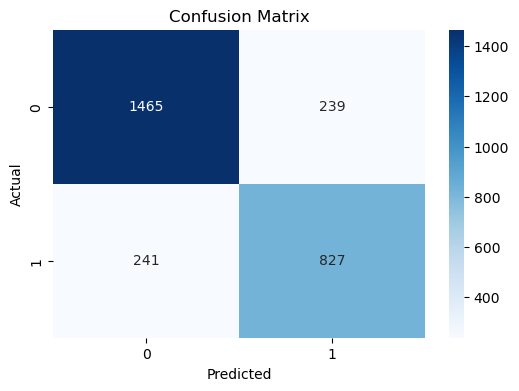

In [218]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

df=pd.read_csv(r"~/Downloads/lead_conversion_cleaned.csv")

# Make a copy to work on
df_encoded = df.copy()

# Identify categorical columns (object or category)
cat_cols = df_encoded.select_dtypes(include=['object', 'category']).columns.tolist()

# Apply Label Encoding (suitable since your cat columns like 'Lead Quality' have few unique values)
le = LabelEncoder()
for col in cat_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col])

# Split features and target
X = df_encoded.drop('Converted', axis=1)
y = df_encoded['Converted']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Train baseline Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Predictions
y_pred = dt_model.predict(X_test)
y_proba = dt_model.predict_proba(X_test)[:, 1]

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Comparing differnet models

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier

df=pd.read_csv(r"~/Downloads/lead_conversion_cleaned.csv")

# Split features and target
X = df.drop('Converted', axis=1)
y = df['Converted']

# Convert object columns to numeric if any
X = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Feature scaling (recommended for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=42)
}

# Results storage
results = []

# Evaluate each model
for name, model in models.items():
    if name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_prob)
    })

# Convert to DataFrame for comparison
results_df = pd.DataFrame(results).sort_values(by='ROC AUC', ascending=False)
print("\nModel Comparison:\n")
print(results_df)

As we can notice that LightGbm is giving us the best ROC AUC values.

# LightGbm with hyperparameter tuning using grid search CV and k-fold cross validation

In [228]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import pandas as pd
import numpy as np

# Assume X and y are already defined and preprocessed
# X: your feature dataframe
# y: your target column

df=pd.read_csv(r"~/Downloads/lead_conversion_cleaned.csv")

# Step 1: Define Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Step 2: Define the parameter grid for LightGBM
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Step 3: Initialize LightGBM Classifier
lgbm = LGBMClassifier(random_state=42)

# Step 4: Set up GridSearchCV with StratifiedKFold
grid_search = GridSearchCV(estimator=lgbm,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=skf,
                           verbose=1,
                           n_jobs=-1)

# Step 5: Fit on full dataset (or train split)
grid_search.fit(X, y)

# Step 6: Best model and its parameters
best_lgbm = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Step 7: Evaluate using StratifiedKFold again on the best model
acc_list, prec_list, rec_list, f1_list, auc_list = [], [], [], [], []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    best_lgbm.fit(X_train, y_train)
    y_pred = best_lgbm.predict(X_test)
    y_proba = best_lgbm.predict_proba(X_test)[:, 1]

    acc_list.append(accuracy_score(y_test, y_pred))
    prec_list.append(precision_score(y_test, y_pred))
    rec_list.append(recall_score(y_test, y_pred))
    f1_list.append(f1_score(y_test, y_pred))
    auc_list.append(roc_auc_score(y_test, y_proba))

# Step 8: Report average metrics
print("\nCross-Validated LightGBM Performance:")
print(f"Accuracy:  {np.mean(acc_list):.4f}")
print(f"Precision: {np.mean(prec_list):.4f}")
print(f"Recall:    {np.mean(rec_list):.4f}")
print(f"F1 Score:  {np.mean(f1_list):.4f}")
print(f"ROC AUC:   {np.mean(auc_list):.4f}")


Fitting 5 folds for each of 72 candidates, totalling 360 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3561, number of negative: 5679
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 438
[LightGBM] [Info] Number of data points in the train set: 9240, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.385390 -> initscore=-0.466734
[LightGBM] [Info] Start training from score -0.466734
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2849, number of negative: 4543
[LightGBM] [Info] Auto-choosing ro

After hyperparameter tuning and gird search CV we can notice that there is slight increment in ROC AOC score which indicated that models perfornace got better.

# Trying stacking model if it can give us better performence

In [229]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from lightgbm import LGBMClassifier

df=pd.read_csv(r"~/Downloads/lead_conversion_cleaned.csv")

# ----- 1. Prepare your features and target -----
X = df.drop(columns='Converted')  # Feature set
y = df['Converted']               # Target variable

# Convert object columns to numeric if any
X = pd.get_dummies(X, drop_first=True)

# Optional train/test split if needed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# ----- 2. Define base models -----
base_learners = [
    ('lr', LogisticRegression(max_iter=1000, solver='liblinear')),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42))
]

# ----- 3. Define meta learner -----
meta_learner = LGBMClassifier(random_state=42)

# ----- 4. Create the stacking classifier -----
stacked_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5,  # Inner CV for base learner predictions
    passthrough=False,  # Use only base learners' predictions
    n_jobs=-1
)

# ----- 5. Cross-validation -----
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

y_pred = cross_val_predict(stacked_model, X, y, cv=cv, method='predict')
y_proba = cross_val_predict(stacked_model, X, y, cv=cv, method='predict_proba')[:, 1]

# ----- 6. Performance Metrics -----
print("📊 Stacked Ensemble Performance:")
print("Accuracy: ", round(accuracy_score(y, y_pred), 4))
print("Precision:", round(precision_score(y, y_pred), 4))
print("Recall:   ", round(recall_score(y, y_pred), 4))
print("F1 Score: ", round(f1_score(y, y_pred), 4))
print("ROC AUC:  ", round(roc_auc_score(y, y_proba), 4))


[LightGBM] [Info] Number of positive: 2849, number of negative: 4543
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 7392, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.385417 -> initscore=-0.466620
[LightGBM] [Info] Start training from score -0.466620
[LightGBM] [Info] Number of positive: 2849, number of negative: 4543
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 755
[LightGBM] [Info] Number of data points in the train set: 7392, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.385417 -> initscore=-0.466620
[LightGBM] [

## Stacking also is giving good results and we can choose either stacking or lightGbm, but we will stick with LightGBM alone—it performed very well, and it's faster, simpler and easier to interpret. 